In [79]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import tensorflow as tf
import time

import collections, numpy

import data_loader as dl
import data_transformer as dt

# helper for setting up the bidirectional, multilayer lstm
def bidirectional_lstm(input_data, num_layers, rnn_size, keep_prob, lengths=None):
    output = input_data
    for layer in range(num_layers):
        with tf.variable_scope('encoder_{}'.format(layer),reuse=tf.AUTO_REUSE):

            cell_fw = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.truncated_normal_initializer(-0.1, 0.1, seed=2))
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, input_keep_prob = keep_prob)

            cell_bw = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.truncated_normal_initializer(-0.1, 0.1, seed=2))
            cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, input_keep_prob = keep_prob)

            outputs, states = tf.nn.bidirectional_dynamic_rnn(cell_fw, 
                                                              cell_bw, 
                                                              output,
                                                              dtype=tf.float32,
                                                              sequence_length=lengths)
            output = tf.concat(outputs,2)

    return output

In [2]:
# change this path to match the path of where you have the
# training_50 and validation files
txt_data_path = '/home/mikey/Data/ProteinNet/casp7_txt/'

The data_lim is important because so far the full 13000 proteins crashes my system with 16Gb of ram

Load training data

In [3]:
file_name = 'training_50'
data_lim = 2000
prim_train, evo_train, dih_train, mask_train = (dl.parse_primary_from_file(txt_data_path + file_name, data_lim), 
                                                dl.parse_evolutionary_from_file(txt_data_path + file_name, data_lim),
                                                dl.load_file('./'+file_name+'_dih.joblib'),
                                                dl.parse_mask_from_file(txt_data_path + file_name, data_lim))
dih_train = dih_train[:data_lim]
len(prim_train), prim_train[0].shape, len(evo_train), evo_train[0].shape, len(dih_train), dih_train[0].shape, len(mask_train), mask_train[0].shape

Loaded data and filtered line endings
Extracted primary data
Encoded primary sequences
Loaded data and filtered line endings
Extracted evolutionary data


100%|██████████| 2000/2000 [00:00<00:00, 68406.95it/s]


Grouped 21's together
Loaded data and filtered line endings
Extracted mask data


(2000, (70, 20), 2000, (70, 21), 2000, (70, 3), 2000, (70,))

Load validation data

In [4]:
file_name = 'validation'
prim_valid, evo_valid, dih_valid, mask_valid = (dl.parse_primary_from_file(txt_data_path + file_name), 
                                                dl.parse_evolutionary_from_file(txt_data_path + file_name),
                                                dl.load_file('./'+ file_name + '_dih.joblib'),
                                                dl.parse_mask_from_file(txt_data_path + file_name))
len(prim_valid), prim_valid[0].shape, len(evo_valid), evo_valid[0].shape, len(dih_valid), dih_valid[0].shape, len(mask_valid), mask_valid[0].shape

Loaded data and filtered line endings
Extracted primary data
Encoded primary sequences
Loaded data and filtered line endings
Extracted evolutionary data


100%|██████████| 224/224 [00:00<00:00, 70371.07it/s]

Grouped 21's together
Loaded data and filtered line endings
Extracted mask data


(224, (269, 20), 224, (269, 21), 224, (269, 3), 224, (269,))

Pad the data and limit protein length. Prepare the data for training

In [5]:
max_len = 500
prim_, evo_, dih_, mask_ = dt.limit_length_and_pad(prim_train, evo_train, dih_train, mask_train, max_len)
x_train, y_train = np.concatenate([prim_, evo_], axis=2), dih_
prim_v, evo_v, dih_v, mask_v = dt.limit_length_and_pad(prim_valid, evo_valid, dih_valid, mask_valid, max_len)
x_valid, y_valid = np.concatenate([prim_v, evo_v], axis=2), dih_v

padded
(1892,) (70, 20)
padded
(1892,) (70, 21)
padded
(1892,) (70, 3)
padded
(1892,) (70, 1)
padded
(213,) (269, 20)
padded
(213,) (269, 21)
padded
(213,) (269, 3)
padded
(213,) (269, 1)


In [150]:
from sklearn.cluster import KMeans
from keras.utils import to_categorical

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0, verbose=0, max_iter=1000).fit(y_train[:500].reshape(-1,3))

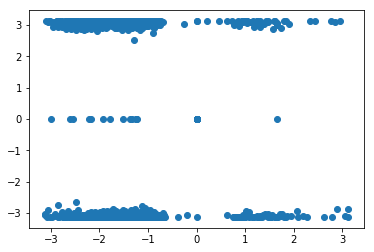

In [154]:
plt.scatter(y_valid[:10][:,:,0], y_valid[:10][:,:,2])

In [209]:
clusters = np.array([[-1.5, 0, -np.pi], [-1.5, 0, np.pi], [-1.5, 2.5, -np.pi], [-1.5, 2.5, np.pi]])
clusters = np.array([[-1.5, 0, 0], [-1.5, 2.5, 0]])
n_clusters = clusters.shape[0]

In [210]:
import scipy
a = np.argmin(scipy.spatial.distance_matrix(y_train.reshape(-1,3), clusters), axis=1).reshape(y_train.shape[0], y_train.shape[1]) + 1
a, np.unique(a)

(array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 2, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]), array([1, 2]))

In [211]:
a[np.logical_not(mask_)] = 0
a, np.unique(a)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 2, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0]]), array([0, 1, 2]))

In [212]:
# y_train_labels_ = kmeans.predict(y_train.reshape(-1,3)).reshape(y_train.shape[0], y_train.shape[1]) + 1
y_train_labels_ = np.argmin(scipy.spatial.distance_matrix(y_train.reshape(-1,3), clusters), 
                            axis=1).reshape(y_train.shape[0], y_train.shape[1]) + 1
# y_train_labels_[y_train[:,:,0]==0] = n_clusters-1
y_train_labels_[np.logical_not(mask_)] = 0
print(y_train_labels_.reshape(-1,).shape, np.sum(y_train_labels_ != -1))

# y_valid_labels_ = kmeans.predict(y_valid.reshape(-1,3)).reshape(y_valid.shape[0], y_valid.shape[1]) + 1
y_valid_labels_ = np.argmin(scipy.spatial.distance_matrix(y_valid.reshape(-1,3), clusters), 
                            axis=1).reshape(y_valid.shape[0], y_valid.shape[1]) + 1
# y_valid_labels_[y_valid[:,:,0]==0] = n_clusters-1
y_valid_labels_[np.logical_not(mask_v)] = 0


# ohe = OneHotEncoder(n_values = n_clusters).fit(y_train_labels)
y_train_labels = to_categorical(y_train_labels_)
y_valid_labels = to_categorical(y_valid_labels_)

y_train_labels.shape, y_valid_labels.shape

(946000,) 946000


((1892, 500, 3), (213, 500, 3))

In [214]:
np.unique(y_train_labels_), np.unique(y_valid_labels_), n_clusters

(array([0, 1, 2]), array([0, 1, 2]), 2)

In [222]:
tf.reset_default_graph()

clusters_tf = tf.constant(np.insert(clusters, 0, -100., axis=0), dtype=np.float32)

X = tf.placeholder(tf.float32, [None, max_len, 41], name="X")
y = tf.placeholder(tf.float32, [None, max_len, n_clusters+1], name='y')
y_angles = tf.placeholder(tf.float32, [None, max_len, 3], name='y_angles')

mask = tf.not_equal(tf.argmax(y, 2), 0)

conv1 = tf.layers.conv1d(X, 32, 5, activation=tf.nn.relu, padding='same')
conv2 = tf.layers.conv1d(conv1, 64, 5, activation=tf.nn.relu, padding='same')
conv3 = tf.layers.conv1d(conv2, 128, 5, activation=tf.nn.relu, padding='same')

# lstm = bidirectional_lstm(X, 1, 32, keep_prob=0.05)

logits = tf.layers.dense(conv2, n_clusters+1, activation='relu')
y_pred = tf.nn.softmax(logits)

y_masked = tf.boolean_mask(y, mask)
logits_masked = tf.boolean_mask(logits, mask)
y_pred_masked = tf.boolean_mask(y_pred, mask)
y_angles_masked = tf.boolean_mask(y_angles, mask)
shape_after_mask = tf.shape(y_masked)
# y_masked = y
# logits_masked = logits
# y_pred_masked = y_pred
rad_pred = tf.divide(tf.einsum('ij,bi->bj', clusters_tf, y_pred_masked), n_clusters+1)

# Difine the loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_masked, logits=logits_masked))

mae = tf.reduce_mean(tf.abs(tf.subtract(rad_pred[:,:2], y_angles_masked[:,:2])))

# Define the optimizer operation
learning_rate = tf.placeholder(tf.float32)

#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

# Variables for prediction and accuracy
prediction = tf.argmax(y_pred_masked, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_masked, 1)), tf.float32))

# Initialize the variables (they are assigned default values)
init = tf.global_variables_initializer()

n_parameters = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
print("Number of parameters:", n_parameters)

Number of parameters: 58179


In [223]:
batch_size = 32
n_epochs = 500

# Start as session
init_learning_rate = 0.001
with tf.Session() as session:

    # Run the initializer
    session.run(init)

    # Training cycle
    for epoch in range(n_epochs):
        print("Epoch:", epoch)
        for b in range(0, x_train.shape[0], batch_size):
            _, loss_value = session.run([optimizer, loss], feed_dict={X: x_train[b:b+batch_size],
                                                                      y: y_train_labels[b:b+batch_size],
                                                                      y_angles: y_train[b:b+batch_size],
                                                                      learning_rate: init_learning_rate})
            
        validation_accuracy, mae_, pred_ = session.run([accuracy, mae, prediction], feed_dict={X: x_valid, y: y_valid_labels, y_angles:y_valid})
        print("loss[epoch=%04d] = %f, val_acc = %f" % (epoch, loss_value, validation_accuracy))    
        print("MAE", mae_)
        print(collections.Counter(pred_))
    
    if epoch % 10 == 0:
        init_learning_rate = init_learning_rate / 1.1
    print("Optimization done")

    # Calculate training accuracy
    train_accuracy_value, pred_train, shape_after_mask_ = session.run([accuracy, prediction, shape_after_mask], 
                                                                      feed_dict={X: x_train, y: y_train_labels,
                                                                                y_angles: y_train})
    print("Train accuracy:", train_accuracy_value)
    print("Shape after mask:", shape_after_mask_)
    
    # Calculate test accuracy
    test_accuracy_value, pred_test, shape_after_mask_ = session.run([accuracy, prediction, shape_after_mask], 
                                                                    feed_dict={X: x_valid, y: y_valid_labels,
                                                                              y_angles: y_valid})
    print("Test accuracy:", test_accuracy_value)
    print("Shape after mask:", shape_after_mask_)

Epoch: 0
loss[epoch=0000] = 0.521927, val_acc = 0.681751
MAE 1.2028283
Counter({2: 19322, 1: 18312})
Epoch: 1
loss[epoch=0001] = 0.484755, val_acc = 0.722060
MAE 1.194354
Counter({1: 19789, 2: 17845})
Epoch: 2
loss[epoch=0002] = 0.464413, val_acc = 0.735372
MAE 1.1898915
Counter({1: 19560, 2: 18074})
Epoch: 3
loss[epoch=0003] = 0.441433, val_acc = 0.744168
MAE 1.1856166
Counter({1: 19565, 2: 18069})
Epoch: 4
loss[epoch=0004] = 0.419973, val_acc = 0.752564
MAE 1.1814535
Counter({1: 19599, 2: 18035})
Epoch: 5
loss[epoch=0005] = 0.405844, val_acc = 0.760456
MAE 1.1776851
Counter({1: 19798, 2: 17836})
Epoch: 6
loss[epoch=0006] = 0.396382, val_acc = 0.765877
MAE 1.1745375
Counter({1: 19956, 2: 17678})
Epoch: 7
loss[epoch=0007] = 0.388626, val_acc = 0.770314
MAE 1.1719102
Counter({1: 20109, 2: 17525})
Epoch: 8
loss[epoch=0008] = 0.382126, val_acc = 0.774486
MAE 1.1699512
Counter({1: 20282, 2: 17352})
Epoch: 9
loss[epoch=0009] = 0.375980, val_acc = 0.777754
MAE 1.1682221
Counter({1: 20367, 2:

loss[epoch=0082] = 0.190103, val_acc = 0.810942
MAE 1.151574
Counter({1: 21690, 2: 15944})
Epoch: 83
loss[epoch=0083] = 0.188004, val_acc = 0.811128
MAE 1.1515256
Counter({1: 21645, 2: 15989})
Epoch: 84
loss[epoch=0084] = 0.186851, val_acc = 0.811367
MAE 1.1515208
Counter({1: 21678, 2: 15956})
Epoch: 85
loss[epoch=0085] = 0.185316, val_acc = 0.811447
MAE 1.1514455
Counter({1: 21725, 2: 15909})
Epoch: 86
loss[epoch=0086] = 0.184064, val_acc = 0.811447
MAE 1.1514163
Counter({1: 21669, 2: 15965})
Epoch: 87
loss[epoch=0087] = 0.182841, val_acc = 0.811474
MAE 1.1513567
Counter({1: 21676, 2: 15958})
Epoch: 88
loss[epoch=0088] = 0.181174, val_acc = 0.811181
MAE 1.1513246
Counter({1: 21655, 2: 15979})
Epoch: 89
loss[epoch=0089] = 0.179856, val_acc = 0.810783
MAE 1.1512612
Counter({1: 21642, 2: 15992})
Epoch: 90
loss[epoch=0090] = 0.178809, val_acc = 0.810995
MAE 1.1513089
Counter({1: 21672, 2: 15962})
Epoch: 91
loss[epoch=0091] = 0.177733, val_acc = 0.810836
MAE 1.1512504
Counter({1: 21660, 2:

loss[epoch=0162] = 0.138122, val_acc = 0.808524
MAE 1.1501893
Counter({1: 21951, 2: 15683})
Epoch: 163
loss[epoch=0163] = 0.137735, val_acc = 0.808551
MAE 1.150145
Counter({1: 21950, 2: 15684})
Epoch: 164
loss[epoch=0164] = 0.137520, val_acc = 0.808524
MAE 1.1501107
Counter({1: 21953, 2: 15681})
Epoch: 165
loss[epoch=0165] = 0.137138, val_acc = 0.808471
MAE 1.1500586
Counter({1: 21941, 2: 15693})
Epoch: 166
loss[epoch=0166] = 0.136776, val_acc = 0.808152
MAE 1.1500721
Counter({1: 21945, 2: 15689})
Epoch: 167
loss[epoch=0167] = 0.136661, val_acc = 0.808285
MAE 1.1501191
Counter({1: 21940, 2: 15694})
Epoch: 168
loss[epoch=0168] = 0.136418, val_acc = 0.808179
MAE 1.1501305
Counter({1: 21930, 2: 15704})
Epoch: 169
loss[epoch=0169] = 0.136147, val_acc = 0.808498
MAE 1.1501157
Counter({1: 21934, 2: 15700})
Epoch: 170
loss[epoch=0170] = 0.135904, val_acc = 0.808551
MAE 1.1500593
Counter({1: 21912, 2: 15722})
Epoch: 171
loss[epoch=0171] = 0.135413, val_acc = 0.808258
MAE 1.1500555
Counter({1: 

loss[epoch=0243] = 0.118196, val_acc = 0.808471
MAE 1.1496967
Counter({1: 21907, 2: 15727})
Epoch: 244
loss[epoch=0244] = 0.117874, val_acc = 0.808365
MAE 1.1496922
Counter({1: 21921, 2: 15713})
Epoch: 245
loss[epoch=0245] = 0.117581, val_acc = 0.808179
MAE 1.1496572
Counter({1: 21936, 2: 15698})
Epoch: 246
loss[epoch=0246] = 0.117582, val_acc = 0.807993
MAE 1.1496468
Counter({1: 21891, 2: 15743})
Epoch: 247
loss[epoch=0247] = 0.117555, val_acc = 0.808019
MAE 1.1496973
Counter({1: 21906, 2: 15728})
Epoch: 248
loss[epoch=0248] = 0.117516, val_acc = 0.807886
MAE 1.1497291
Counter({1: 21903, 2: 15731})
Epoch: 249
loss[epoch=0249] = 0.117295, val_acc = 0.807886
MAE 1.1497625
Counter({1: 21923, 2: 15711})
Epoch: 250
loss[epoch=0250] = 0.117087, val_acc = 0.808046
MAE 1.1497569
Counter({1: 21925, 2: 15709})
Epoch: 251
loss[epoch=0251] = 0.116776, val_acc = 0.808046
MAE 1.149772
Counter({1: 21939, 2: 15695})
Epoch: 252
loss[epoch=0252] = 0.116655, val_acc = 0.807594
MAE 1.1497769
Counter({1: 

loss[epoch=0324] = 0.107197, val_acc = 0.806664
MAE 1.1495122
Counter({1: 21855, 2: 15779})
Epoch: 325
loss[epoch=0325] = 0.107170, val_acc = 0.806744
MAE 1.1495317
Counter({1: 21880, 2: 15754})
Epoch: 326
loss[epoch=0326] = 0.106892, val_acc = 0.806611
MAE 1.1495174
Counter({1: 21849, 2: 15785})
Epoch: 327
loss[epoch=0327] = 0.107048, val_acc = 0.806531
MAE 1.1495095
Counter({1: 21846, 2: 15788})
Epoch: 328
loss[epoch=0328] = 0.106949, val_acc = 0.806824
MAE 1.1494937
Counter({1: 21855, 2: 15779})
Epoch: 329
loss[epoch=0329] = 0.106690, val_acc = 0.806372
MAE 1.1494606
Counter({1: 21850, 2: 15784})
Epoch: 330
loss[epoch=0330] = 0.106752, val_acc = 0.806452
MAE 1.1494839
Counter({1: 21871, 2: 15763})
Epoch: 331
loss[epoch=0331] = 0.106521, val_acc = 0.806159
MAE 1.1494917
Counter({1: 21878, 2: 15756})
Epoch: 332
loss[epoch=0332] = 0.106453, val_acc = 0.806239
MAE 1.1494718
Counter({1: 21877, 2: 15757})
Epoch: 333
loss[epoch=0333] = 0.106318, val_acc = 0.806319
MAE 1.1494648
Counter({1:

loss[epoch=0404] = 0.104279, val_acc = 0.804671
MAE 1.1496131
Counter({1: 21906, 2: 15728})
Epoch: 405
loss[epoch=0405] = 0.104189, val_acc = 0.804724
MAE 1.1496316
Counter({1: 21918, 2: 15716})
Epoch: 406
loss[epoch=0406] = 0.103901, val_acc = 0.805282
MAE 1.1496056
Counter({1: 21907, 2: 15727})
Epoch: 407
loss[epoch=0407] = 0.103538, val_acc = 0.804857
MAE 1.1495597
Counter({1: 21899, 2: 15735})
Epoch: 408
loss[epoch=0408] = 0.103449, val_acc = 0.804990
MAE 1.1495447
Counter({1: 21930, 2: 15704})
Epoch: 409
loss[epoch=0409] = 0.103524, val_acc = 0.804937
MAE 1.1495264
Counter({1: 21958, 2: 15676})
Epoch: 410
loss[epoch=0410] = 0.103424, val_acc = 0.805203
MAE 1.1495255
Counter({1: 21976, 2: 15658})
Epoch: 411
loss[epoch=0411] = 0.103374, val_acc = 0.805309
MAE 1.1495153
Counter({1: 22004, 2: 15630})
Epoch: 412
loss[epoch=0412] = 0.103643, val_acc = 0.805282
MAE 1.1495488
Counter({1: 21993, 2: 15641})
Epoch: 413
loss[epoch=0413] = 0.103627, val_acc = 0.804751
MAE 1.1495636
Counter({1:

loss[epoch=0484] = 0.101671, val_acc = 0.804220
MAE 1.1497464
Counter({1: 22029, 2: 15605})
Epoch: 485
loss[epoch=0485] = 0.101562, val_acc = 0.804299
MAE 1.149732
Counter({1: 22062, 2: 15572})
Epoch: 486
loss[epoch=0486] = 0.101547, val_acc = 0.804007
MAE 1.1497275
Counter({1: 22077, 2: 15557})
Epoch: 487
loss[epoch=0487] = 0.101160, val_acc = 0.804193
MAE 1.1497285
Counter({1: 22068, 2: 15566})
Epoch: 488
loss[epoch=0488] = 0.101495, val_acc = 0.804406
MAE 1.1497829
Counter({1: 22058, 2: 15576})
Epoch: 489
loss[epoch=0489] = 0.101182, val_acc = 0.804352
MAE 1.1497489
Counter({1: 22058, 2: 15576})
Epoch: 490
loss[epoch=0490] = 0.100940, val_acc = 0.804485
MAE 1.1497142
Counter({1: 22037, 2: 15597})
Epoch: 491
loss[epoch=0491] = 0.100549, val_acc = 0.804565
MAE 1.1496766
Counter({1: 22040, 2: 15594})
Epoch: 492
loss[epoch=0492] = 0.100561, val_acc = 0.804512
MAE 1.1496837
Counter({1: 22040, 2: 15594})
Epoch: 493
loss[epoch=0493] = 0.100480, val_acc = 0.804512
MAE 1.1496732
Counter({1: 

2